### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Data analysis

In [2]:
dataset = pd.read_json('../data/dataset_2weeks.jsonl', lines=True)
dataset = dataset[dataset.type.eq('edit')].reset_index(drop=True)

#### What is distribution of changes made by users, bots and no bots

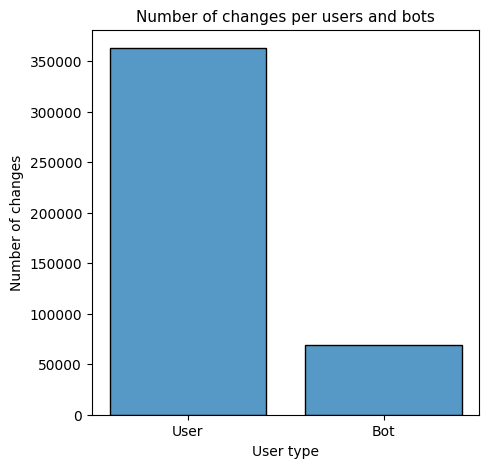

In [3]:
sns.histplot(data=dataset, x='bot', discrete=True, shrink=0.8)
plt.title('Number of changes per users and bots', fontsize=11)
plt.xlabel('User type')
plt.ylabel('Number of changes')
plt.xticks([0, 1], ['User', 'Bot'])

fig = plt.gcf()
fig.set_size_inches(5, 5)

#### When the edits were made

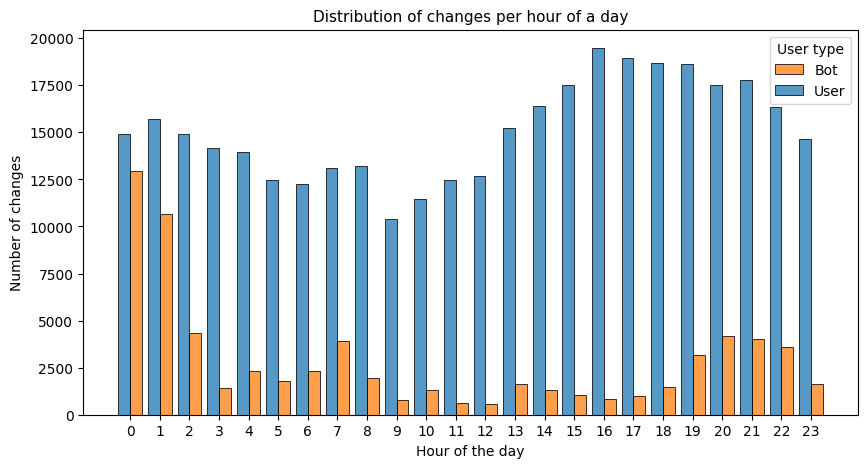

In [4]:
dataset['day'] = dataset.timestamp.dt.day
dataset['hour'] = dataset.timestamp.dt.hour

sns.histplot(x='hour', hue='bot', data=dataset, multiple='dodge', discrete=True, shrink=0.8)
plt.xlabel('Hour of the day')
plt.ylabel('Number of changes')
plt.legend(['Bot', 'User'], title='User type')
plt.xticks(np.arange(0, 24))
plt.title('Distribution of changes per hour of a day', fontsize=11)

fig = plt.gcf()
fig.set_size_inches(10, 5)

### How fast changes are made

In [5]:
dataset = dataset.sort_values(by=['user', 'timestamp'])

dataset['time_delta'] = dataset.groupby('user')['timestamp'].diff()
user_time_delta_data = dataset.dropna(subset=['time_delta'])

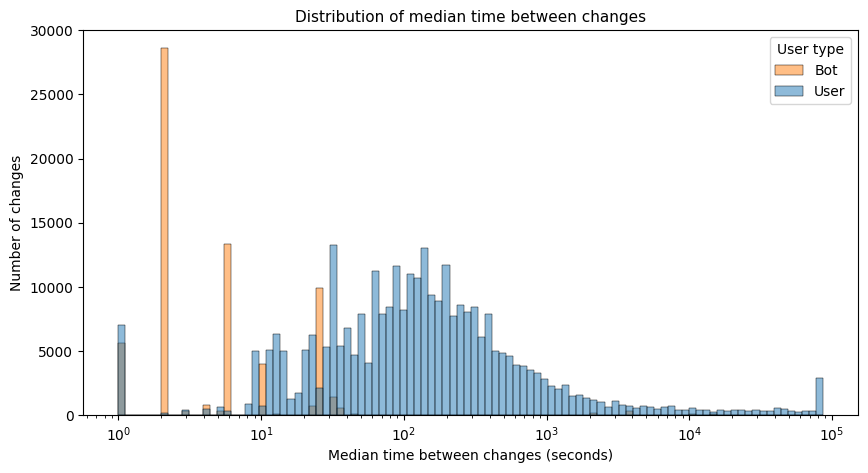

In [6]:
users_time_delta = pd.merge(
    user_time_delta_data.groupby('user')['time_delta'].median(),
    user_time_delta_data.set_index('user')['bot'],
    left_index=True,
    right_index=True
)
users_time_delta['time_delta'] = users_time_delta['time_delta'].astype('timedelta64[s]').astype(int)
users_time_delta['bot'] = users_time_delta['bot'].apply(lambda x: 'Bot' if x else 'User')
users_time_delta.loc[users_time_delta['time_delta'] > 86400, 'time_delta'] = 86400

ax = sns.histplot(data=users_time_delta, x='time_delta', hue='bot', bins=100, log_scale=True)

plt.title('Distribution of median time between changes', fontsize=11)
plt.ylabel('Number of changes')
plt.xlabel('Median time between changes (seconds)')
plt.legend(['Bot', 'User'], title='User type')

fig = plt.gcf()
fig.set_size_inches(10, 5)

In [7]:
bot_series = dataset.groupby('user').bot.last()

In [8]:
users_time_delta = user_time_delta_data.groupby('user')['time_delta'].mean()
users_time_delta = pd.merge(users_time_delta, bot_series, left_index=True, right_index=True)
users_time_delta['time_delta'].dropna(inplace=True)
users_time_delta['time_delta'] = users_time_delta['time_delta'].astype('timedelta64[s]').astype(int)

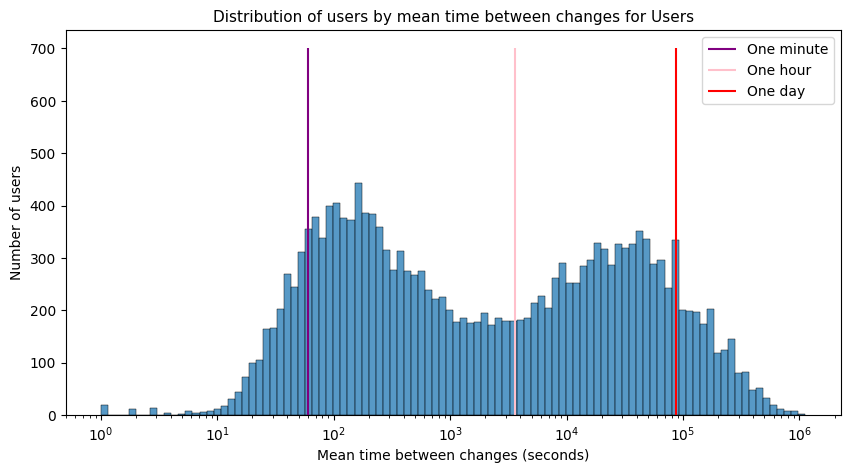

In [9]:
users_time_delta_user = users_time_delta[users_time_delta['bot'] == False]

sns.histplot(data=users_time_delta_user, x='time_delta', bins=100, log_scale=True)
plt.title('Distribution of users by mean time between changes for Users', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean time between changes (seconds)')

plt.vlines(60, 0, 700, color='purple', label='One minute')
plt.vlines(3600, 0, 700, color='pink', label='One hour')
plt.vlines(86400, 0, 700, color='red', label='One day')
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 5)

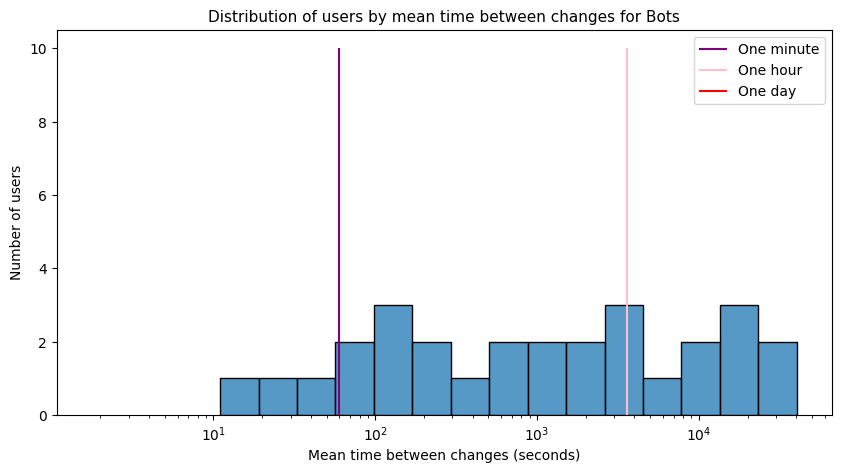

In [10]:
users_time_delta_bot = users_time_delta[users_time_delta['bot'] == True]

sns.histplot(data=users_time_delta_bot, x='time_delta', bins=15, log_scale=True)
plt.title('Distribution of users by mean time between changes for Bots', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean time between changes (seconds)')

plt.vlines(60, 0, 10, color='purple', label='One minute')
plt.vlines(3600, 0, 10, color='pink', label='One hour')
plt.vlines(86400, 0, 10, color='red', label='One day')
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 5)

In [11]:
changes_per_day = dataset.groupby(['user', 'day']).day.count().groupby('user').mean()
changes_per_day = pd.merge(changes_per_day, bot_series, left_index=True, right_index=True)

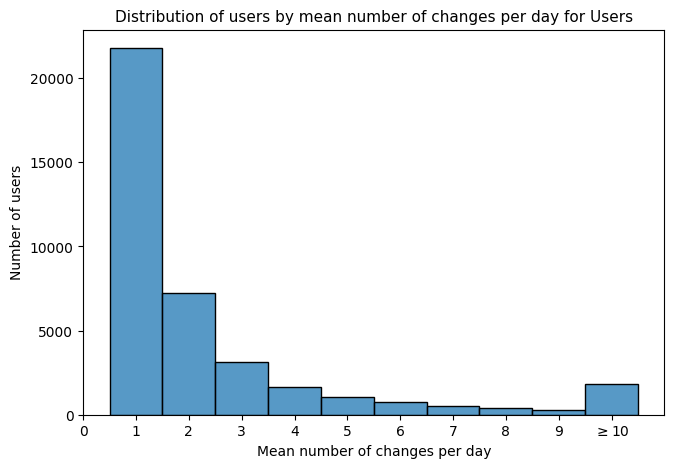

In [12]:
changes_per_day_user = changes_per_day[changes_per_day['bot'] == False]

changes_per_day_user.loc[changes_per_day_user['day'] > 10, 'day'] = 10
ax = sns.histplot(data=changes_per_day_user, x='day', bins=10, discrete=True)
plt.title('Distribution of users by mean number of changes per day for Users', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean number of changes per day')
plt.xticks(np.arange(0, 11))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels[-1] = '$\geq10$'
ax.set_xticklabels(xlabels);

fig = plt.gcf()
fig.set_size_inches(7.5, 5)

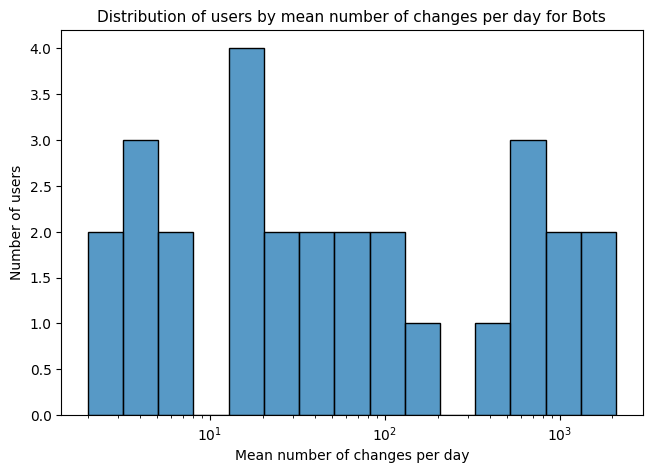

In [13]:
changes_per_day_bot = changes_per_day[changes_per_day['bot'] == True]

ax = sns.histplot(data=changes_per_day_bot, x='day', bins=15, log_scale=True)
plt.title('Distribution of users by mean number of changes per day for Bots', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean number of changes per day')

fig = plt.gcf()
fig.set_size_inches(7.5, 5)

In [14]:
changes_per_hour = dataset.groupby(['user', 'day', 'hour']).hour.count().groupby('user').mean()
changes_per_hour = pd.merge(changes_per_hour, bot_series, left_index=True, right_index=True)

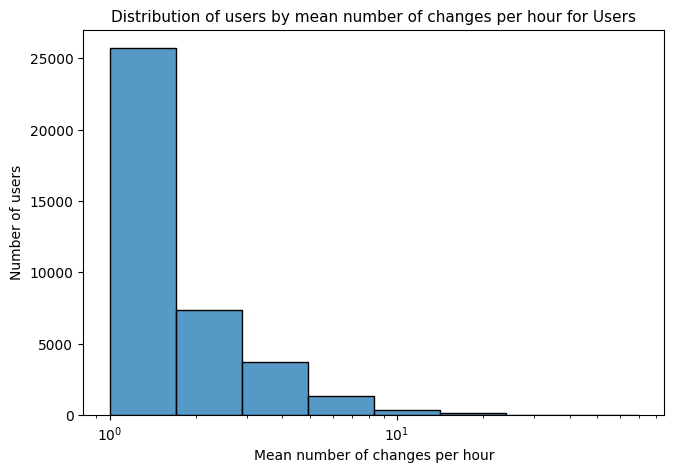

In [15]:
changes_per_hour_user = changes_per_hour[changes_per_hour['bot'] == False]

ax = sns.histplot(data=changes_per_hour_user, x='hour', bins=8, log_scale=True)
plt.title('Distribution of users by mean number of changes per hour for Users', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean number of changes per hour')

fig = plt.gcf()
fig.set_size_inches(7.5, 5)

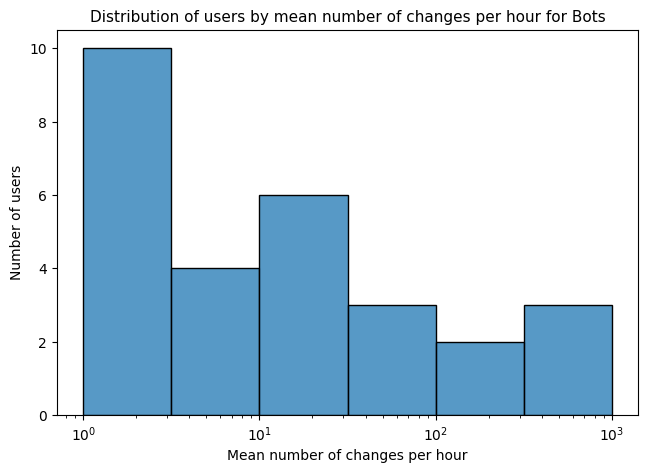

In [16]:
changes_per_hour_bot = changes_per_hour[changes_per_hour['bot'] == True]
changes_per_hour_bot.loc[changes_per_hour_bot['hour'] > 1000, 'hour'] = 1000
ax = sns.histplot(data=changes_per_hour_bot, x='hour', log_scale=True)
plt.title('Distribution of users by mean number of changes per hour for Bots', fontsize=11)
plt.ylabel('Number of users')
plt.xlabel('Mean number of changes per hour')

fig = plt.gcf()
fig.set_size_inches(7.5, 5)